# Use Builtin RNN, GRU, and LSTM
## Major Used Concepts
### 1. MNIST Dataset for Image Classification
### 2. Treat the Image as Sequence Instead of Squeezing it into 1D i.e. (one dimenstion of the image will be considered as a sequence, the other dimention will be considered as a feature size)

In [26]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

In [27]:
# device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [28]:
# set important parameters
input_size = 28 # because 1 row = 28
sequence_size = 28 # because 1 col = 28
n_layers = 2
hidden_size = 128 # can be tried different sizes
n_classes = 10 # because MNIST data will have total 10 classes
l_rate = 0.001
batch_size = 100
n_epochs = 2

In [29]:
# MNIST data & transformation of data into tensor
train_data = torchvision.datasets.MNIST(root='./data', train=True, transform=transforms.ToTensor(), download=True)

test_data = torchvision.datasets.MNIST(root='./data', train=False, transform=transforms.ToTensor())
print(train_data, test_data)

Dataset MNIST
    Number of datapoints: 60000
    Root location: ./data
    Split: Train
    StandardTransform
Transform: ToTensor() Dataset MNIST
    Number of datapoints: 10000
    Root location: ./data
    Split: Test
    StandardTransform
Transform: ToTensor()


In [30]:
# load batchsize of 100
train_loader = torch.utils.data.DataLoader(dataset=train_data, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_data, batch_size=batch_size, shuffle=False)


In [31]:
for i in test_loader:
    print(i[0].shape,i[1].shape)

torch.Size([100, 1, 28, 28]) torch.Size([100])
torch.Size([100, 1, 28, 28]) torch.Size([100])
torch.Size([100, 1, 28, 28]) torch.Size([100])
torch.Size([100, 1, 28, 28]) torch.Size([100])
torch.Size([100, 1, 28, 28]) torch.Size([100])
torch.Size([100, 1, 28, 28]) torch.Size([100])
torch.Size([100, 1, 28, 28]) torch.Size([100])
torch.Size([100, 1, 28, 28]) torch.Size([100])
torch.Size([100, 1, 28, 28]) torch.Size([100])
torch.Size([100, 1, 28, 28]) torch.Size([100])
torch.Size([100, 1, 28, 28]) torch.Size([100])
torch.Size([100, 1, 28, 28]) torch.Size([100])
torch.Size([100, 1, 28, 28]) torch.Size([100])
torch.Size([100, 1, 28, 28]) torch.Size([100])
torch.Size([100, 1, 28, 28]) torch.Size([100])
torch.Size([100, 1, 28, 28]) torch.Size([100])
torch.Size([100, 1, 28, 28]) torch.Size([100])
torch.Size([100, 1, 28, 28]) torch.Size([100])
torch.Size([100, 1, 28, 28]) torch.Size([100])
torch.Size([100, 1, 28, 28]) torch.Size([100])
torch.Size([100, 1, 28, 28]) torch.Size([100])
torch.Size([1

In [32]:
# test and have look of 1 batch of data
examples = iter(train_loader)
samples, labels = next(examples)
print(samples.shape, labels.shape)
print(samples[0])

torch.Size([100, 1, 28, 28]) torch.Size([100])
tensor([[[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          

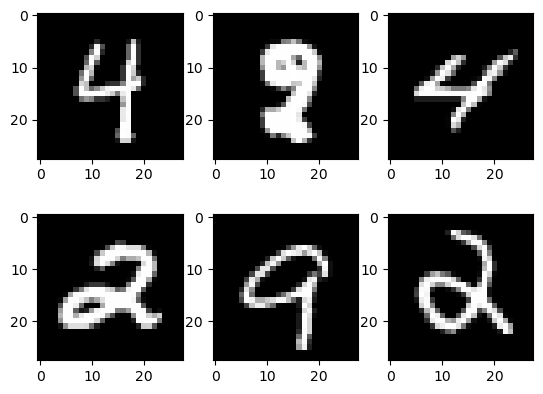

In [33]:
# plot some samples
for i in range(6):
    plt.subplot(2, 3, i+1)
    plt.imshow(samples[i][0], cmap='gray')
plt.show()

# 1. RNN Model

In [34]:
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, n_layers, n_classes):
        super(RNN, self).__init__()
        self.n_layers = n_layers
        self.hidden_size = hidden_size
        
        # batch_first indicates that the batch should be first dimention
        # input_shape = (batch_size, sequence_size, input_size)
        self.rnn = nn.RNN(input_size, hidden_size, n_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, n_classes)
        
    def forward(self, inputs):
        # 2 inputs are required in the befinning -> 1) initial hidden state, 2) input
        # inputs.size(0) presents batch size
        h0 = torch.zeros(self.n_layers, inputs.size(0), self.hidden_size).to(device)
        
        # deliver 2 outputs -> 1) output of all the steps, 2) h_n for the step n
        # we require output only
        # output = (batch_size, sequence_size, hidden_size) = (N, 28, 128)
        output, _ = self.rnn(inputs, h0)
        
        # we require (batch_size, hidden_size) = (N, 128)
        output = output[:, -1, :]
        output = self.fc(output)
        
        return output
        

In [35]:
model = RNN(input_size, hidden_size, n_layers, n_classes)

In [36]:
# loss and optimizer
criterion =  nn.CrossEntropyLoss() # nn.CrossEntropyLoss() automaticsally applies Softmax
optimizer = torch.optim.Adam(model.parameters(), lr=l_rate)

In [37]:
# training loop
n_steps = len(train_loader)
for epoch in range(n_epochs):
    for i, (images, labels) in enumerate(train_loader):
        # origin shape -> 100, 1, 28, 28
        # required shape -> 100, 28, 28
        images = images.reshape(-1, sequence_size, input_size).to(device)
        labels = labels.to(device)
        
        # forward pass
        out = model(images)
        loss = criterion(out, labels)
        
        # backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if (i+1) % 100 == 0:
            print(f'epoch {epoch+1} / {n_epochs}, step {i+1} / {n_steps}, loss = {loss.item():.4f}')

epoch 1 / 2, step 100 / 600, loss = 1.0533
epoch 1 / 2, step 200 / 600, loss = 0.7983
epoch 1 / 2, step 300 / 600, loss = 0.5220
epoch 1 / 2, step 400 / 600, loss = 0.5440
epoch 1 / 2, step 500 / 600, loss = 0.3396
epoch 1 / 2, step 600 / 600, loss = 0.5086
epoch 2 / 2, step 100 / 600, loss = 0.5925
epoch 2 / 2, step 200 / 600, loss = 0.4452
epoch 2 / 2, step 300 / 600, loss = 0.1920
epoch 2 / 2, step 400 / 600, loss = 0.4130
epoch 2 / 2, step 500 / 600, loss = 0.4564
epoch 2 / 2, step 600 / 600, loss = 0.3406


In [38]:
# testing model
with torch.no_grad():
    n_correct = 0
    n_samples = 0
    for images, labels in test_loader:
        # origin shape -> 100, 1, 28, 28
        # required shape -> 100, 28, 28
        images = images.reshape(-1, sequence_size, input_size).to(device)
        labels = labels.to(device)
        
        out = model(images)
        
        # value, index
        _, predictions = torch.max(out, 1)
        n_samples += labels.shape[0]
        n_correct += (predictions == labels).sum().item()
        
    accuracy = 100.0 * n_correct / n_samples
    print(f'accuracy = {accuracy}')

accuracy = 91.99


# 2. GRU Model
### Code is same as RNN
### Inputs paramters are same

In [39]:
class GRU(nn.Module):
    def __init__(self, input_size, hidden_size, n_layers, n_classes):
        super(GRU, self).__init__()
        self.n_layers = n_layers
        self.hidden_size = hidden_size
        
        # batch_first indicates that the batch should be first dimention
        # input_shape = (batch_size, sequence_size, input_size)
        self.gru = nn.GRU(input_size, hidden_size, n_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, n_classes)
        
    def forward(self, inputs):
        # 2 inputs are required in the befinning -> 1) initial hidden state, 2) input
        # inputs.size(0) presents batch size
        h0 = torch.zeros(self.n_layers, inputs.size(0), self.hidden_size).to(device)
        
        # deliver 2 outputs -> 1) output of all the steps, 2) h_n for the step n
        # we require output only
        # output = (batch_size, sequence_size, hidden_size) = (N, 28, 128)
        output, _ = self.gru(inputs, h0)
        
        # we require (batch_size, hidden_size) = (N, 128)
        output = output[:, -1, :]
        output = self.fc(output)
        
        return output
        

In [40]:
model = GRU(input_size, hidden_size, n_layers, n_classes)

In [41]:
# loss and optimizer
criterion =  nn.CrossEntropyLoss() # nn.CrossEntropyLoss() automaticsally applies Softmax
optimizer = torch.optim.Adam(model.parameters(), lr=l_rate)

In [42]:
# training loop
n_steps = len(train_loader)
for epoch in range(n_epochs):
    for i, (images, labels) in enumerate(train_loader):
        # origin shape -> 100, 1, 28, 28
        # required shape -> 100, 28, 28
        images = images.reshape(-1, sequence_size, input_size).to(device)
        labels = labels.to(device)
        
        # forward pass
        out = model(images)
        loss = criterion(out, labels)
        
        # backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if (i+1) % 100 == 0:
            print(f'epoch {epoch+1} / {n_epochs}, step {i+1} / {n_steps}, loss = {loss.item():.4f}')

epoch 1 / 2, step 100 / 600, loss = 0.6384
epoch 1 / 2, step 200 / 600, loss = 0.3792
epoch 1 / 2, step 300 / 600, loss = 0.2611
epoch 1 / 2, step 400 / 600, loss = 0.1157
epoch 1 / 2, step 500 / 600, loss = 0.1610
epoch 1 / 2, step 600 / 600, loss = 0.1392
epoch 2 / 2, step 100 / 600, loss = 0.0897
epoch 2 / 2, step 200 / 600, loss = 0.0600
epoch 2 / 2, step 300 / 600, loss = 0.1132
epoch 2 / 2, step 400 / 600, loss = 0.2805
epoch 2 / 2, step 500 / 600, loss = 0.1234
epoch 2 / 2, step 600 / 600, loss = 0.1496


In [43]:
# testing model
with torch.no_grad():
    n_correct = 0
    n_samples = 0
    for images, labels in test_loader:
        # origin shape -> 100, 1, 28, 28
        # required shape -> 100, 28, 28
        images = images.reshape(-1, sequence_size, input_size).to(device)
        labels = labels.to(device)
        
        out = model(images)
        
        # value, index
        _, predictions = torch.max(out, 1)
        n_samples += labels.shape[0]
        n_correct += (predictions == labels).sum().item()
        
    accuracy = 100.0 * n_correct / n_samples
    print(f'accuracy = {accuracy}')

accuracy = 97.29


# 3. LSTM Model
### Code is same as RNN or GRU
### The only difference: Require an initial Cell state (c0)
### Input paramters are still same

In [44]:
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, n_layers, n_classes):
        super(LSTM, self).__init__()
        self.n_layers = n_layers
        self.hidden_size = hidden_size
        
        # batch_first indicates that the batch should be first dimention
        # input_shape = (batch_size, sequence_size, input_size)
        self.lstm = nn.LSTM(input_size, hidden_size, n_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, n_classes)
        
    def forward(self, inputs):
        # 2 inputs are required in the befinning -> 1) initial hidden state, 2) input
        # inputs.size(0) presents batch size
        h0 = torch.zeros(self.n_layers, inputs.size(0), self.hidden_size).to(device)
        
        # initial tensor for initial Cell state
        c0 = torch.zeros(self.n_layers, inputs.size(0), self.hidden_size).to(device)
        
        # deliver 2 outputs -> 1) output of all the steps, 2) h_n for the step n
        # we require output only
        # output = (batch_size, sequence_size, hidden_size) = (N, 28, 128)
        output, _ = self.lstm(inputs, (h0, c0))
        
        # we require (batch_size, hidden_size) = (N, 128)
        output = output[:, -1, :]
        output = self.fc(output)
        
        return output
        

In [45]:
model = LSTM(input_size, hidden_size, n_layers, n_classes)

In [46]:
# loss and optimizer
criterion =  nn.CrossEntropyLoss() # nn.CrossEntropyLoss() automaticsally applies Softmax
optimizer = torch.optim.Adam(model.parameters(), lr=l_rate)

In [47]:
# training loop
n_steps = len(train_loader)
for epoch in range(n_epochs):
    for i, (images, labels) in enumerate(train_loader):
        # origin shape -> 100, 1, 28, 28
        # required shape -> 100, 28, 28
        images = images.reshape(-1, sequence_size, input_size).to(device)
        labels = labels.to(device)
        
        # forward pass
        out = model(images)
        loss = criterion(out, labels)
        
        # backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if (i+1) % 100 == 0:
            print(f'epoch {epoch+1} / {n_epochs}, step {i+1} / {n_steps}, loss = {loss.item():.4f}')

epoch 1 / 2, step 100 / 600, loss = 0.6825
epoch 1 / 2, step 200 / 600, loss = 0.4827
epoch 1 / 2, step 300 / 600, loss = 0.2832
epoch 1 / 2, step 400 / 600, loss = 0.2277
epoch 1 / 2, step 500 / 600, loss = 0.2124
epoch 1 / 2, step 600 / 600, loss = 0.1907
epoch 2 / 2, step 100 / 600, loss = 0.1045
epoch 2 / 2, step 200 / 600, loss = 0.1406
epoch 2 / 2, step 300 / 600, loss = 0.1437
epoch 2 / 2, step 400 / 600, loss = 0.1081
epoch 2 / 2, step 500 / 600, loss = 0.1270
epoch 2 / 2, step 600 / 600, loss = 0.0599


In [48]:
# testing model
with torch.no_grad():
    n_correct = 0
    n_samples = 0
    for images, labels in test_loader:
        # origin shape -> 100, 1, 28, 28
        # required shape -> 100, 28, 28
        images = images.reshape(-1, sequence_size, input_size).to(device)
        labels = labels.to(device)
        
        out = model(images)
        
        # value, index
        _, predictions = torch.max(out, 1)
        n_samples += labels.shape[0]
        n_correct += (predictions == labels).sum().item()
        
    accuracy = 100.0 * n_correct / n_samples
    print(f'accuracy = {accuracy}')

accuracy = 97.04
